# Lightgbm

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load data
train.csv and test.csv are obtained using Data_Merging.ipynb from all the provided files. To load files pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) method used.

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(307511, 199)


In [5]:
#display(train.head(2))

In [4]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


### Load possible outliers (Optional)
Outliers are found using [isolation forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html), indexes of outliers are saved into file 'isolation_forest_outliers.npy'.

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

### Removing service and target columns
Let's split target (Y) column from train set and leave there only feature vectors (X). Another column to drop is SK_ID_CURR, it is different for each row thus it is not useful because does not add any information.

In [5]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [6]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [7]:
targets.shape

(307511, 1)

### Drop redundant columns
There are number of columns with high correlation almost or equial to 1. See Data_Exploration.ipynb notebook Correlations section for details.

In [8]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [9]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features
Lightgbm algorithm nateively works with categorical features. To process those it needs a parameter 'categorical_feature' set , see [lightgbm parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html).

In [10]:
cat_features = train.select_dtypes('object').columns.tolist()

In [11]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning
Stratified K-Fold algorithm is used to split data set into train and validation sets to best use all the data in the data set. To find appropriate parameters Random Search technique is used. Params to find through were changed several times each closer to best parameters found on previous step.

In [15]:
# Lightbm parameters
params = {
    'learning_rate': [0.05],
    'n_estimators': [10000],
    'num_leaves': [32, 64],
    'max_depth': [-1, 7],
    'min_child_samples': [80, 160],
    'reg_alpha': [2.0, 4.0],
    'reg_lambda': [1.0, 2.0],
    'max_bin': [255]
}

# to store results for each instance of parameter sampler
cv_results = []

# Iterate over random combonations of parameters
for i, param_smple in enumerate(list(ParameterSampler(params, 10))):
    print('Iteration %i, params: %s' % (i, param_smple))
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []
    train_scores = []
    params_ = dict(param_smple)
    params_['params'] = param_smple
    start = time.time()
    fold_i = 0
    model = lightgbm.LGBMClassifier(n_estimators=param_smple['n_estimators'], objective='binary', 
                                    class_weight='balanced', learning_rate=param_smple['learning_rate'], 
                                    num_leaves=param_smple['num_leaves'], max_depth=param_smple['max_depth'],
                                    reg_alpha=param_smple['reg_alpha'], reg_lambda=param_smple['reg_lambda'], 
                                    min_child_samples=param_smple['min_child_samples'],
                                    subsample=0.8, n_jobs=6, random_state=4242, max_bin=param_smple['max_bin'])

    # use k-fold to use train and validation sets to test how algorithm learned
    for train_indices, valid_indices in k_fold.split(train, targets):
        train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
        valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    
        model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                      eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        params_['train_score_%s' % fold_i] = model.best_score_['train']['auc']
        params_['valid_score_%s' % fold_i] = model.best_score_['valid']['auc']
        fold_i += 1
    
    end = time.time()
    params_['fit_time'] = end - start
    params_['mean_train_score'] = np.mean(train_scores)
    params_['mean_valid_score'] = np.mean(valid_scores)
    cv_results.append(params_)
    

Iteration 0, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 2.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799395	valid's auc: 0.765144
[200]	train's auc: 0.825386	valid's auc: 0.772813
[300]	train's auc: 0.844485	valid's auc: 0.774921
[400]	train's auc: 0.860025	valid's auc: 0.775358
[500]	train's auc: 0.873535	valid's auc: 0.775464
[600]	train's auc: 0.885917	valid's auc: 0.775596
Early stopping, best iteration is:
[555]	train's auc: 0.880612	valid's auc: 0.77574
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.798488	valid's auc: 0.767914
[200]	train's auc: 0.824301	valid's auc: 0.774598
[300]	train's auc: 0.843218	valid's auc: 0.776464
[400]	train's auc: 0.859115	valid's auc: 0.776663
Early stopping, best iteration is:
[376]	train's auc: 0.855431	valid's auc: 0.776956
Training until validation

[100]	train's auc: 0.828543	valid's auc: 0.77064
[200]	train's auc: 0.86904	valid's auc: 0.776138
[300]	train's auc: 0.897393	valid's auc: 0.776528
Early stopping, best iteration is:
[292]	train's auc: 0.895344	valid's auc: 0.776776
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828881	valid's auc: 0.771527
[200]	train's auc: 0.869424	valid's auc: 0.776055
[300]	train's auc: 0.897456	valid's auc: 0.775831
Early stopping, best iteration is:
[211]	train's auc: 0.873181	valid's auc: 0.77617
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828623	valid's auc: 0.769925
[200]	train's auc: 0.869602	valid's auc: 0.774022
[300]	train's auc: 0.897497	valid's auc: 0.77358
Early stopping, best iteration is:
[223]	train's auc: 0.876793	valid's auc: 0.774418
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.828713	valid's auc: 0.771929
[200]	train's auc: 0.869343	valid's auc: 0.776336
[300]	trai

[300]	train's auc: 0.847184	valid's auc: 0.777371
Early stopping, best iteration is:
[261]	train's auc: 0.83992	valid's auc: 0.777561
Iteration 9, params: {'max_depth': 7, 'learning_rate': 0.05, 'num_leaves': 32, 'reg_lambda': 1.0, 'n_estimators': 10000, 'max_bin': 255, 'reg_alpha': 4.0, 'min_child_samples': 80}
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799299	valid's auc: 0.765324
[200]	train's auc: 0.825003	valid's auc: 0.772993
[300]	train's auc: 0.843875	valid's auc: 0.775043
[400]	train's auc: 0.859915	valid's auc: 0.77536
[500]	train's auc: 0.873677	valid's auc: 0.774751
Early stopping, best iteration is:
[427]	train's auc: 0.864019	valid's auc: 0.775476
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.799251	valid's auc: 0.768471
[200]	train's auc: 0.82481	valid's auc: 0.775481
[300]	train's auc: 0.843495	valid's auc: 0.776877
[400]	train's auc: 0.859298	valid's auc: 0.777335
[500]	train's auc: 0.873271

Create DataFrame from stored results of each parameter sample to benefit from visualization of DataFrames.

In [19]:
df_results = pd.DataFrame(cv_results)
df_results.sort_values('mean_valid_score', axis=0)

,fit_time,learning_rate,max_bin,max_depth,mean_train_score,mean_valid_score,min_child_samples,n_estimators,num_leaves,params,reg_alpha,reg_lambda,train_score_0,train_score_1,train_score_2,train_score_3,train_score_4,valid_score_0,valid_score_1,valid_score_2,valid_score_3,valid_score_4
2,209.345991,0.05,255,7,0.879643,0.774872,160,10000,64,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.884810,0.878929,0.870778,0.883375,0.880324,0.773982,0.775994,0.775934,0.773367,0.775080
4,221.092630,0.05,255,-1,0.884262,0.775698,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.891202,0.895344,0.873181,0.876793,0.884790,0.774554,0.776776,0.776170,0.774418,0.776569
7,230.559262,0.05,255,-1,0.886008,0.775903,160,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.885867,0.880709,0.900700,0.870250,0.892515,0.775475,0.776003,0.776658,0.774745,0.776636
5,219.593719,0.05,255,-1,0.881182,0.775955,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,1.0,0.892885,0.882636,0.872181,0.884327,0.873883,0.775252,0.776981,0.776253,0.774913,0.776378
3,243.125517,0.05,255,-1,0.888726,0.776094,80,10000,64,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",4.0,2.0,0.903517,0.900325,0.869330,0.892090,0.878368,0.775331,0.776650,0.776021,0.774950,0.777520
6,227.609989,0.05,255,-1,0.862194,0.776147,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,1.0,0.873431,0.859316,0.880181,0.851305,0.846737,0.775149,0.777162,0.777237,0.774826,0.776359
9,220.591223,0.05,255,7,0.853910,0.776186,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,1.0,0.864019,0.859661,0.842670,0.856077,0.847123,0.775476,0.777402,0.776402,0.774785,0.776862
8,205.577855,0.05,255,-1,0.850824,0.776347,160,10000,32,"{'max_depth': -1, 'learning_rate': 0.05, 'num_...",2.0,2.0,0.861142,0.847452,0.862335,0.843271,0.839920,0.776083,0.777526,0.776533,0.774035,0.777561
0,209.558289,0.05,255,7,0.855997,0.776403,80,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",4.0,2.0,0.880612,0.855431,0.845372,0.845025,0.853547,0.775740,0.776956,0.777227,0.774894,0.777196
1,226.068312,0.05,255,7,0.859351,0.776409,160,10000,32,"{'max_depth': 7, 'learning_rate': 0.05, 'num_l...",2.0,2.0,0.851097,0.873188,0.866143,0.843619,0.862705,0.775473,0.777569,0.776632,0.774995,0.777378


Let's see best parameters, that sample which has the best score.

In [20]:
best_index = df_results.mean_valid_score.idxmax()
df_results.iloc[best_index]['params']

{'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 7,
 'min_child_samples': 160,
 'n_estimators': 10000,
 'num_leaves': 32,
 'reg_alpha': 2.0,
 'reg_lambda': 2.0}

In [21]:
df_results.iloc[best_index]

fit_time                                                       226.068
learning_rate                                                     0.05
max_bin                                                            255
max_depth                                                            7
mean_train_score                                              0.859351
mean_valid_score                                              0.776409
min_child_samples                                                  160
n_estimators                                                     10000
num_leaves                                                          32
params               {'max_depth': 7, 'learning_rate': 0.05, 'num_l...
reg_alpha                                                            2
reg_lambda                                                           2
train_score_0                                                 0.851097
train_score_1                                                 0.873188
train_

### Model K-Fold Execution
Keep parameters separate to remember what parameters were used.

In [25]:
base_parameters = {
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'max_bin': 255
}

previous_params = {
    'learning_rate': 0.005,
    'n_estimators': 32000,
    'num_leaves': 32,
    'max_depth': 7,
    'min_child_samples': 160,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0,
    'max_bin': 255
}

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 32000,
    'num_leaves': 16,
    'max_depth': 5,
    'min_child_samples': 80,
    'reg_alpha': 2.0,
    'reg_lambda': 2.0,
    'max_bin': 127
}

tuned_params = {
    'learning_rate': 0.005,
     'max_bin': 127,
     'max_depth': 4,
     'min_child_samples': 60,
     'n_estimators': 10000,
     'num_leaves': 7,
     'reg_alpha': 10.0,
     'reg_lambda': 10.0
}

To evaluate how model works cross validation is used. K-Fold technique applied, it works the next way, train data data is split into k folds, then one of folds is chosen to be validation set others to be train set. Models are trained and evaluated with each fold, e.g. model1 trained on Fold1 + Fold2 + Fold3 + Fold4 and evaluated on Fold5. The AUC scores are collected for each model and summarized.

In [ ]:
features = np.array(train)
test_features = np.array(test)

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

params = tuned_params

for train_indices, valid_indices in k_fold.split(features, targets):
    model = lightgbm.LGBMClassifier(n_estimators=params['n_estimators'], objective='binary', 
                                class_weight='balanced', learning_rate=params['learning_rate'], 
                                num_leaves=params['num_leaves'], max_depth=params['max_depth'],
                                reg_alpha=params['reg_alpha'], reg_lambda=params['reg_lambda'],
                                min_child_sample=params['min_child_samples'],
                                subsample=0.8, n_jobs=6, random_state=4242, max_bin=params['max_bin'])
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    test_features = test
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.714818	valid's auc: 0.709828
[200]	train's auc: 0.723555	valid's auc: 0.717431
[300]	train's auc: 0.73282	valid's auc: 0.725476
[400]	train's auc: 0.740211	valid's auc: 0.731988
[500]	train's auc: 0.746389	valid's auc: 0.737422
[600]	train's auc: 0.752085	valid's auc: 0.742595
[700]	train's auc: 0.75639	valid's auc: 0.74646
[800]	train's auc: 0.7599	valid's auc: 0.749569
[900]	train's auc: 0.762788	valid's auc: 0.752042
[1000]	train's auc: 0.765243	valid's auc: 0.754161
[1100]	train's auc: 0.767398	valid's auc: 0.755984
[1200]	train's auc: 0.769263	valid's auc: 0.75755
[1300]	train's auc: 0.770922	valid's auc: 0.758975
[1400]	train's auc: 0.772411	valid's auc: 0.760161
[1500]	train's auc: 0.773804	valid's auc: 0.761281
[1600]	train's auc: 0.775103	valid's auc: 0.762338
[1700]	train's auc: 0.776241	valid's auc: 0.763148
[1800]	train's auc: 0.77729	valid's auc: 0.763883
[1900]	train's auc: 0.778322	valid'

### Plots

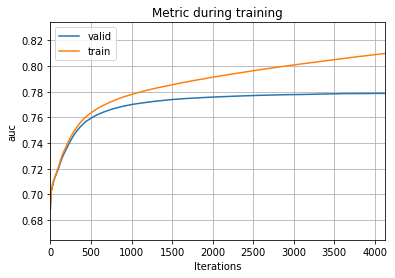

In [22]:
lightgbm.plot_metric(model)

In [12]:
#lightgbm.plot_tree(model)

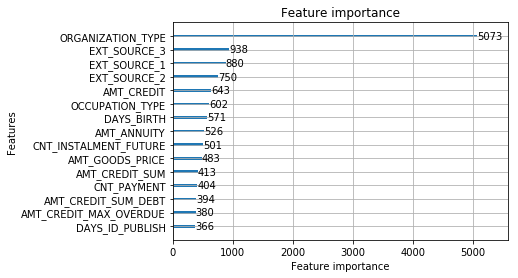

In [23]:
lightgbm.plot_importance(model, max_num_features=15)

### Submission

In [24]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'